# Libraries

In [67]:
import numpy as np
import scipy
from scipy import signal
import matplotlib.pyplot as plt
from pathlib import Path
import sys

root = str(Path().resolve().parent)
if root not in sys.path:
    sys.path.append(root)
print(*sys.path, sep="\n")

%matplotlib ipympl
# %matplotlib inline

/usr/lib/python312.zip
/usr/lib/python3.12
/usr/lib/python3.12/lib-dynload

/home/ryanwtsai/repos/rfdsp_sim/python/venv/lib/python3.12/site-packages
/home/ryanwtsai/repos/rfdsp_sim/python


In [21]:
from importlib import reload
from rfdsppy import calc, ofdm, rf_analog as rfa, rf_tx_fw, \
    tonegen, digital_filter_design, rx_dfe_impcomp as rx_impcomp, \
        digital_hw_algo as dighw, plotting

reload(calc)
reload(ofdm)
reload(rfa)
reload(rf_tx_fw)
reload(tonegen)
reload(digital_filter_design)
reload(rx_impcomp)
reload(dighw)
reload(plotting)

<module 'rfdsppy.plotting' from '/home/ryanwtsai/repos/rfdsp_sim/python/rfdsppy/plotting.py'>

# FD RSB

In [205]:
# Generate sample waveform

nsym = 14
modorder = 64
bw = 20
scs = 15
num_sc = 1200
start_sc = 600-round(num_sc/2)
en_tprecode = False
osr = 8
wola = 1
wg = ofdm.OFDMWavGen(bw, scs, modorder, start_sc, num_sc=num_sc, en_tprecode=en_tprecode, osr=osr, wola=wola)

x, x_standard = wg.generate(nsym)
cfg = wg.get_demod_params()
fs = cfg.get("fs")
wola_len = cfg.get("wola_len")
print(f"Fs (MHz) = {fs}")

Fs (MHz) = 245.76


In [210]:
gd = round((gii.size-1)/2)
x_padded = np.concatenate((x, np.zeros(gd)))

Q_comp = x_padded.imag - signal.lfilter(giq, 1, x_padded.real)
I_comp = signal.lfilter(gii, 1, x_padded.real)

x_comp = I_comp + 1j*Q_comp
x_comp = x_comp[gd:]
print(x_comp.size)
print(x.size)

245598
245598


In [212]:
np.abs(x_comp).sum()
# np.abs(x).sum()


np.float64(451.0686125013112)

In [213]:
# Pass through BBF

delta = 0.07

obw = num_sc*scs/1000
wp = obw/fs
ws = (fs/2-2*obw)/(fs/2)
gpass = 6
gstop = 50

b, a = digital_filter_design.iir_bbf(wp, ws, gpass, gstop, en_plot=False)
b_i, a_i = digital_filter_design.iir_bbf(wp*(1+delta), ws*(1-delta), gpass, gstop, en_plot=False)
b_q, a_q = digital_filter_design.iir_bbf(wp*(1-delta), ws*(1+delta), gpass, gstop, en_plot=False)

x_bbf = signal.lfilter(b, a, x)

# x_i = signal.lfilter(b_i, a_i, x.real)
# x_q = signal.lfilter(b_q, a_q, x.imag)
x_i = signal.lfilter(b_i, a_i, x_comp.real)
x_q = signal.lfilter(b_q, a_q, x_comp.imag)
x_fd_rsb = x_i + 1j*x_q

# py, fy = calc.psd(x_bbf, fs, fs/2**12)
# px, fx = calc.psd(x, fs, fs/2**12)

# fig, axs = plt.subplots(dpi=150)
# axs.plot(fx, 10*np.log10(px), label="BBF Input", linewidth=5)
# axs.plot(fy, 10*np.log10(py), label="BBF Output")
# axs.set_title(f"BBF")
# axs.set_xlabel("Frequency (MHz)")
# axs.set_ylabel("PSD (dBm/Bin)")
# axs.grid()
# axs.legend(loc="lower center")

digital_filter_design.iir_bbf()
Filter order = 3
Maximum passband loss (dB) = 5.825
Minimum stopband attenuation (dB) = 54.4



digital_filter_design.iir_bbf()
Filter order = 3
Maximum passband loss (dB) = 5.959
Minimum stopband attenuation (dB) = 50.1



digital_filter_design.iir_bbf()
Filter order = 3
Maximum passband loss (dB) = 5.671
Minimum stopband attenuation (dB) = 59.4





In [ ]:
# Visualize the FD mismatch

w, hi = signal.freqz(b_i, a_i, worN=2**16, fs=2)
_, hq = signal.freqz(b_q, a_q, worN=2**16, fs=2)

fig, axs = plt.subplots(nrows=2, dpi=100, figsize=(6, 8))
axs[0].plot(w, 20*np.log10(np.abs(hi)), label="I")
axs[1].plot(w, np.angle(hi), label="I")
axs[0].plot(w, 20*np.log10(np.abs(hq)), label="Q")
axs[1].plot(w, np.angle(hq), label="Q")
axs[0].set_title("Magnitude Response (dB)")
axs[1].set_title("Phase Response (rad)")
axs[0].legend()
axs[1].legend()
axs[0].grid()
axs[1].grid()
axs[0].set_xlim(left=0, right=wp*1.5)
axs[1].set_xlim(left=0, right=wp*1.5)
axs[0].set_ylim(bottom=-10, top=0)
axs[0].vlines([wp], ymin=-20, ymax=0, colors='r')

EVM, no mismatch: 3.05 %
SNR, no mismatch: 30.31 dB
EVM, with mismatch: 731.74 %
SNR, with mismatch: -17.29 dB


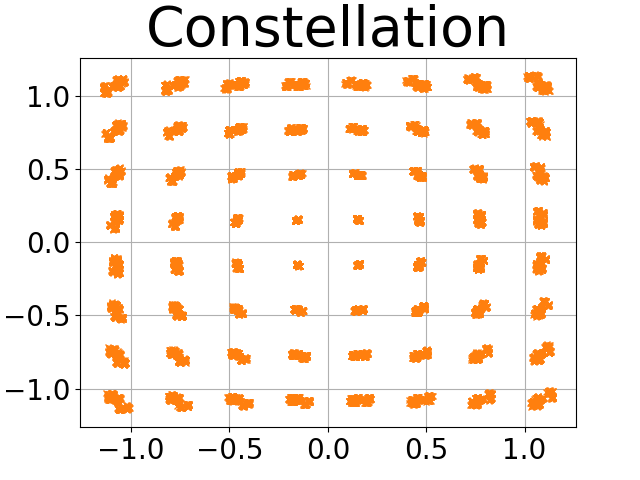

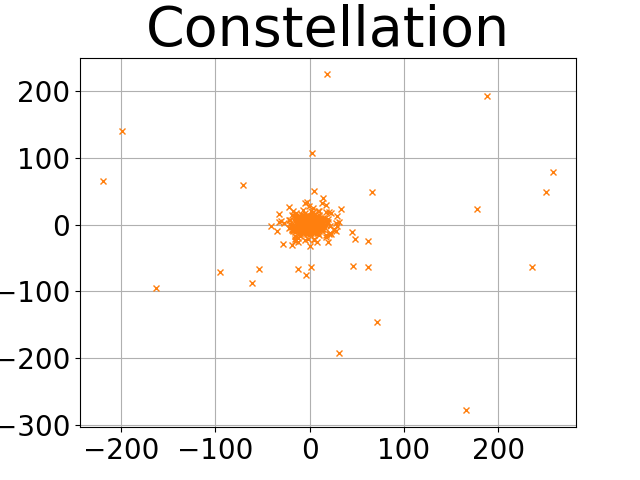

In [214]:
evm = wg.calculate_evm(x[round(wola_len/2):], x_bbf[round(wola_len/2):], en_plot=True, en_fd_eq=True)
print(f"EVM, no mismatch: {round(evm,2)} %")
print(f"SNR, no mismatch: {round(-20*np.log10(evm/100),2)} dB")

evm = wg.calculate_evm(x[round(wola_len/2):], x_fd_rsb[round(wola_len/2):], en_plot=True, en_fd_eq=True)
print(f"EVM, with mismatch: {round(evm,2)} %")
print(f"SNR, with mismatch: {round(-20*np.log10(evm/100),2)} dB")

# Measurement

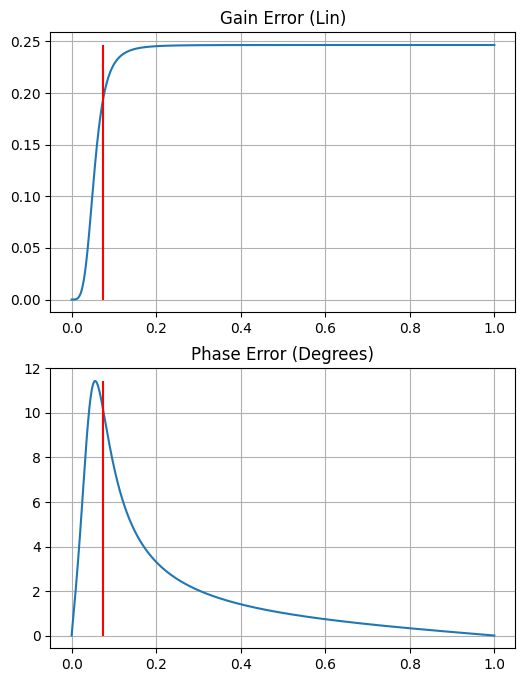

In [26]:
# Measure and then try FIR equalizer

# First, just use the actual frequency response

ep = (np.abs(hi)-np.abs(hq))/np.abs(hi)
theta = np.angle(hi)-np.angle(hq)
theta_deg = theta*180/np.pi

fig, axs = plt.subplots(nrows=2, dpi=100, figsize=(6, 8))
axs[0].plot(w, ep)
axs[1].plot(w, theta_deg)
axs[0].set_title("Gain Error (Lin)")
axs[1].set_title("Phase Error (Degrees)")
axs[0].grid()
axs[1].grid()
# axs[0].set_xlim(left=0, right=wp*3)
# axs[1].set_xlim(left=0, right=wp*3)
# axs[0].set_ylim(bottom=-10, top=0)
axs[0].vlines([wp], ymin=ep.min(), ymax=ep.max(), colors='r')
axs[1].vlines([wp], ymin=theta_deg.min(), ymax=theta_deg.max(), colors='r')

In [28]:
w.max()

np.float64(0.9999847412109375)

In [31]:
np.nonzero(w > wp*3)

(array([14401, 14402, 14403, ..., 65533, 65534, 65535], shape=(51135,)),)

In [30]:
np.sum(w <= wp*3)

np.int64(14401)

In [185]:
idx = 14402
H = 1/((1 + ep[:idx])*np.cos(theta[:idx]))
omega = w[:idx]

H = np.concatenate((H, [0.6, 0.6]))
omega = np.concatenate((omega, [0.3, 1]))
print(H.size)
print(omega.size)

14404
14404


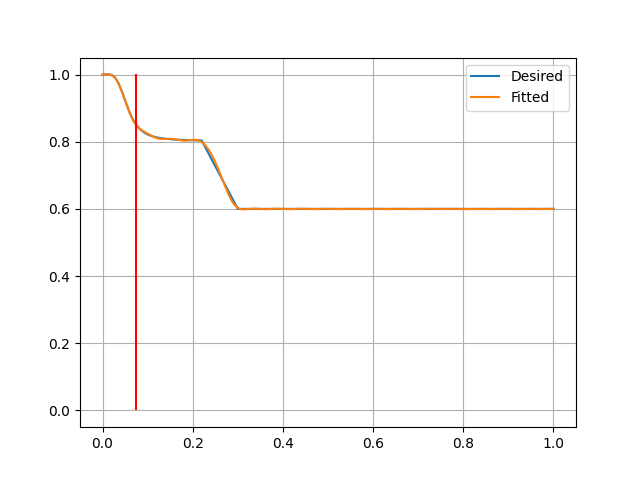

In [191]:
W = np.ones(round(H.size/2))
W[:round(np.sum(omega <= wp)/2)] = 10
gii = signal.firls(71, omega, H, weight=W)
gii = gii/gii.sum()

wii, hii = signal.freqz(gii, worN=2**16, fs=2)

fig, axs = plt.subplots(dpi=100)
axs.plot(omega, H, label="Desired")
axs.plot(wii, np.abs(hii), label="Fitted")
axs.legend()
axs.grid()
axs.vlines([wp], ymin=0, ymax=H.max(), colors='r')
# axs.set_ylim(bottom=1, top=H.max())
# axs.set_xlim(left=0, right=0.5)

In [178]:
idx = 14402
H = np.tan(theta[:idx])
omega = w[:idx]

H = np.concatenate((H, [0.05, 0.05]))
omega = np.concatenate((omega, [0.3, 1]))
print(H.size)
print(omega.size)

14404
14404


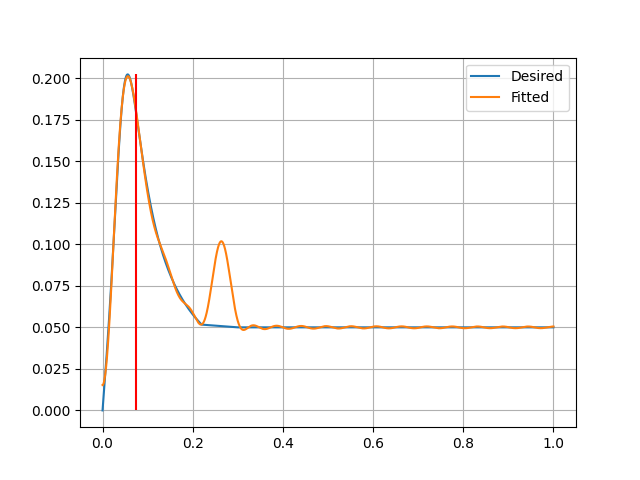

In [184]:
W = np.ones(round(H.size/2))
W[:round(np.sum(omega <= wp)/2)] = 100
giq = signal.firls(71, omega, H, weight=W)
# giq = giq/giq.sum()

wiq, hiq = signal.freqz(giq, worN=2**16, fs=2)

fig, axs = plt.subplots(dpi=100)
axs.plot(omega, H, label="Desired")
axs.plot(wiq, np.abs(hiq), label="Fitted")
axs.legend()
axs.grid()
axs.vlines([wp], ymin=0, ymax=H.max(), colors='r')
# axs.set_ylim(bottom=1, top=H.max())
# axs.set_xlim(left=0, right=0.5)